In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, confusion_matrix

# Load the pre-scaled data (First format)
file_path = "diabetes_scale.txt"  # Replace with your actual path
data, target = load_svmlight_file(file_path)

# Convert the sparse matrix to a dense format
data_dense = data.toarray()

# Convert the sparse matrix to a dense format
data_dense = data.toarray()

print("Data shape:", data_dense.shape)




Data shape: (768, 8)


In [2]:
print("First 5 samples:", data_dense[:5])

First 5 samples: [[-0.294118    0.487437    0.180328   -0.292929   -1.          0.00149028
  -0.53117    -0.0333333 ]
 [-0.882353   -0.145729    0.0819672  -0.414141   -1.         -0.207153
  -0.766866   -0.666667  ]
 [-0.0588235   0.839196    0.0491803  -1.         -1.         -0.305514
  -0.492741   -0.633333  ]
 [-0.882353   -0.105528    0.0819672  -0.535354   -0.777778   -0.162444
  -0.923997   -1.        ]
 [-1.          0.376884   -0.344262   -0.292929   -0.602837    0.28465
   0.887276   -0.6       ]]


In [3]:
print("First 5 target labels:", target[:5])

First 5 target labels: [-1.  1. -1.  1. -1.]


In [4]:
# Convert NumPy array to DataFrame for better visualization
df = pd.DataFrame(data_dense)
df.columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
              'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
df['Outcome'] = target



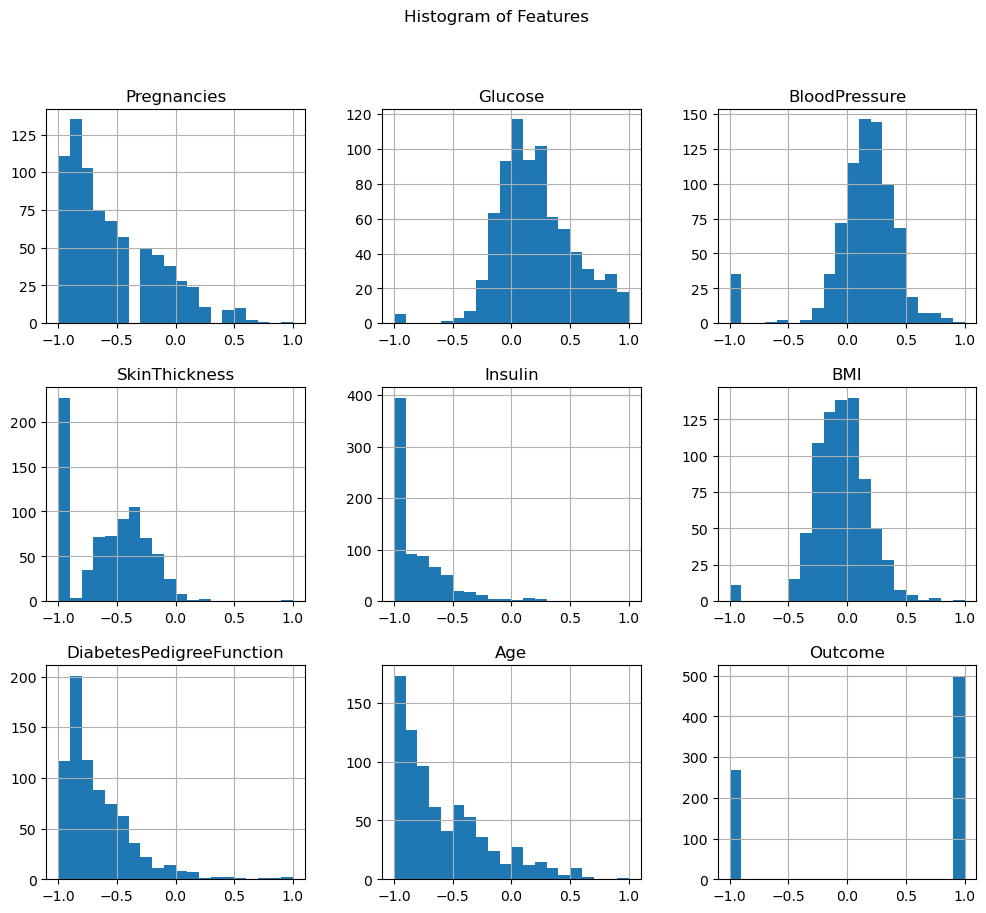

In [5]:
# Plot histograms
df.hist(bins=20, figsize=(12, 10))
plt.suptitle('Histogram of Features')
plt.show()

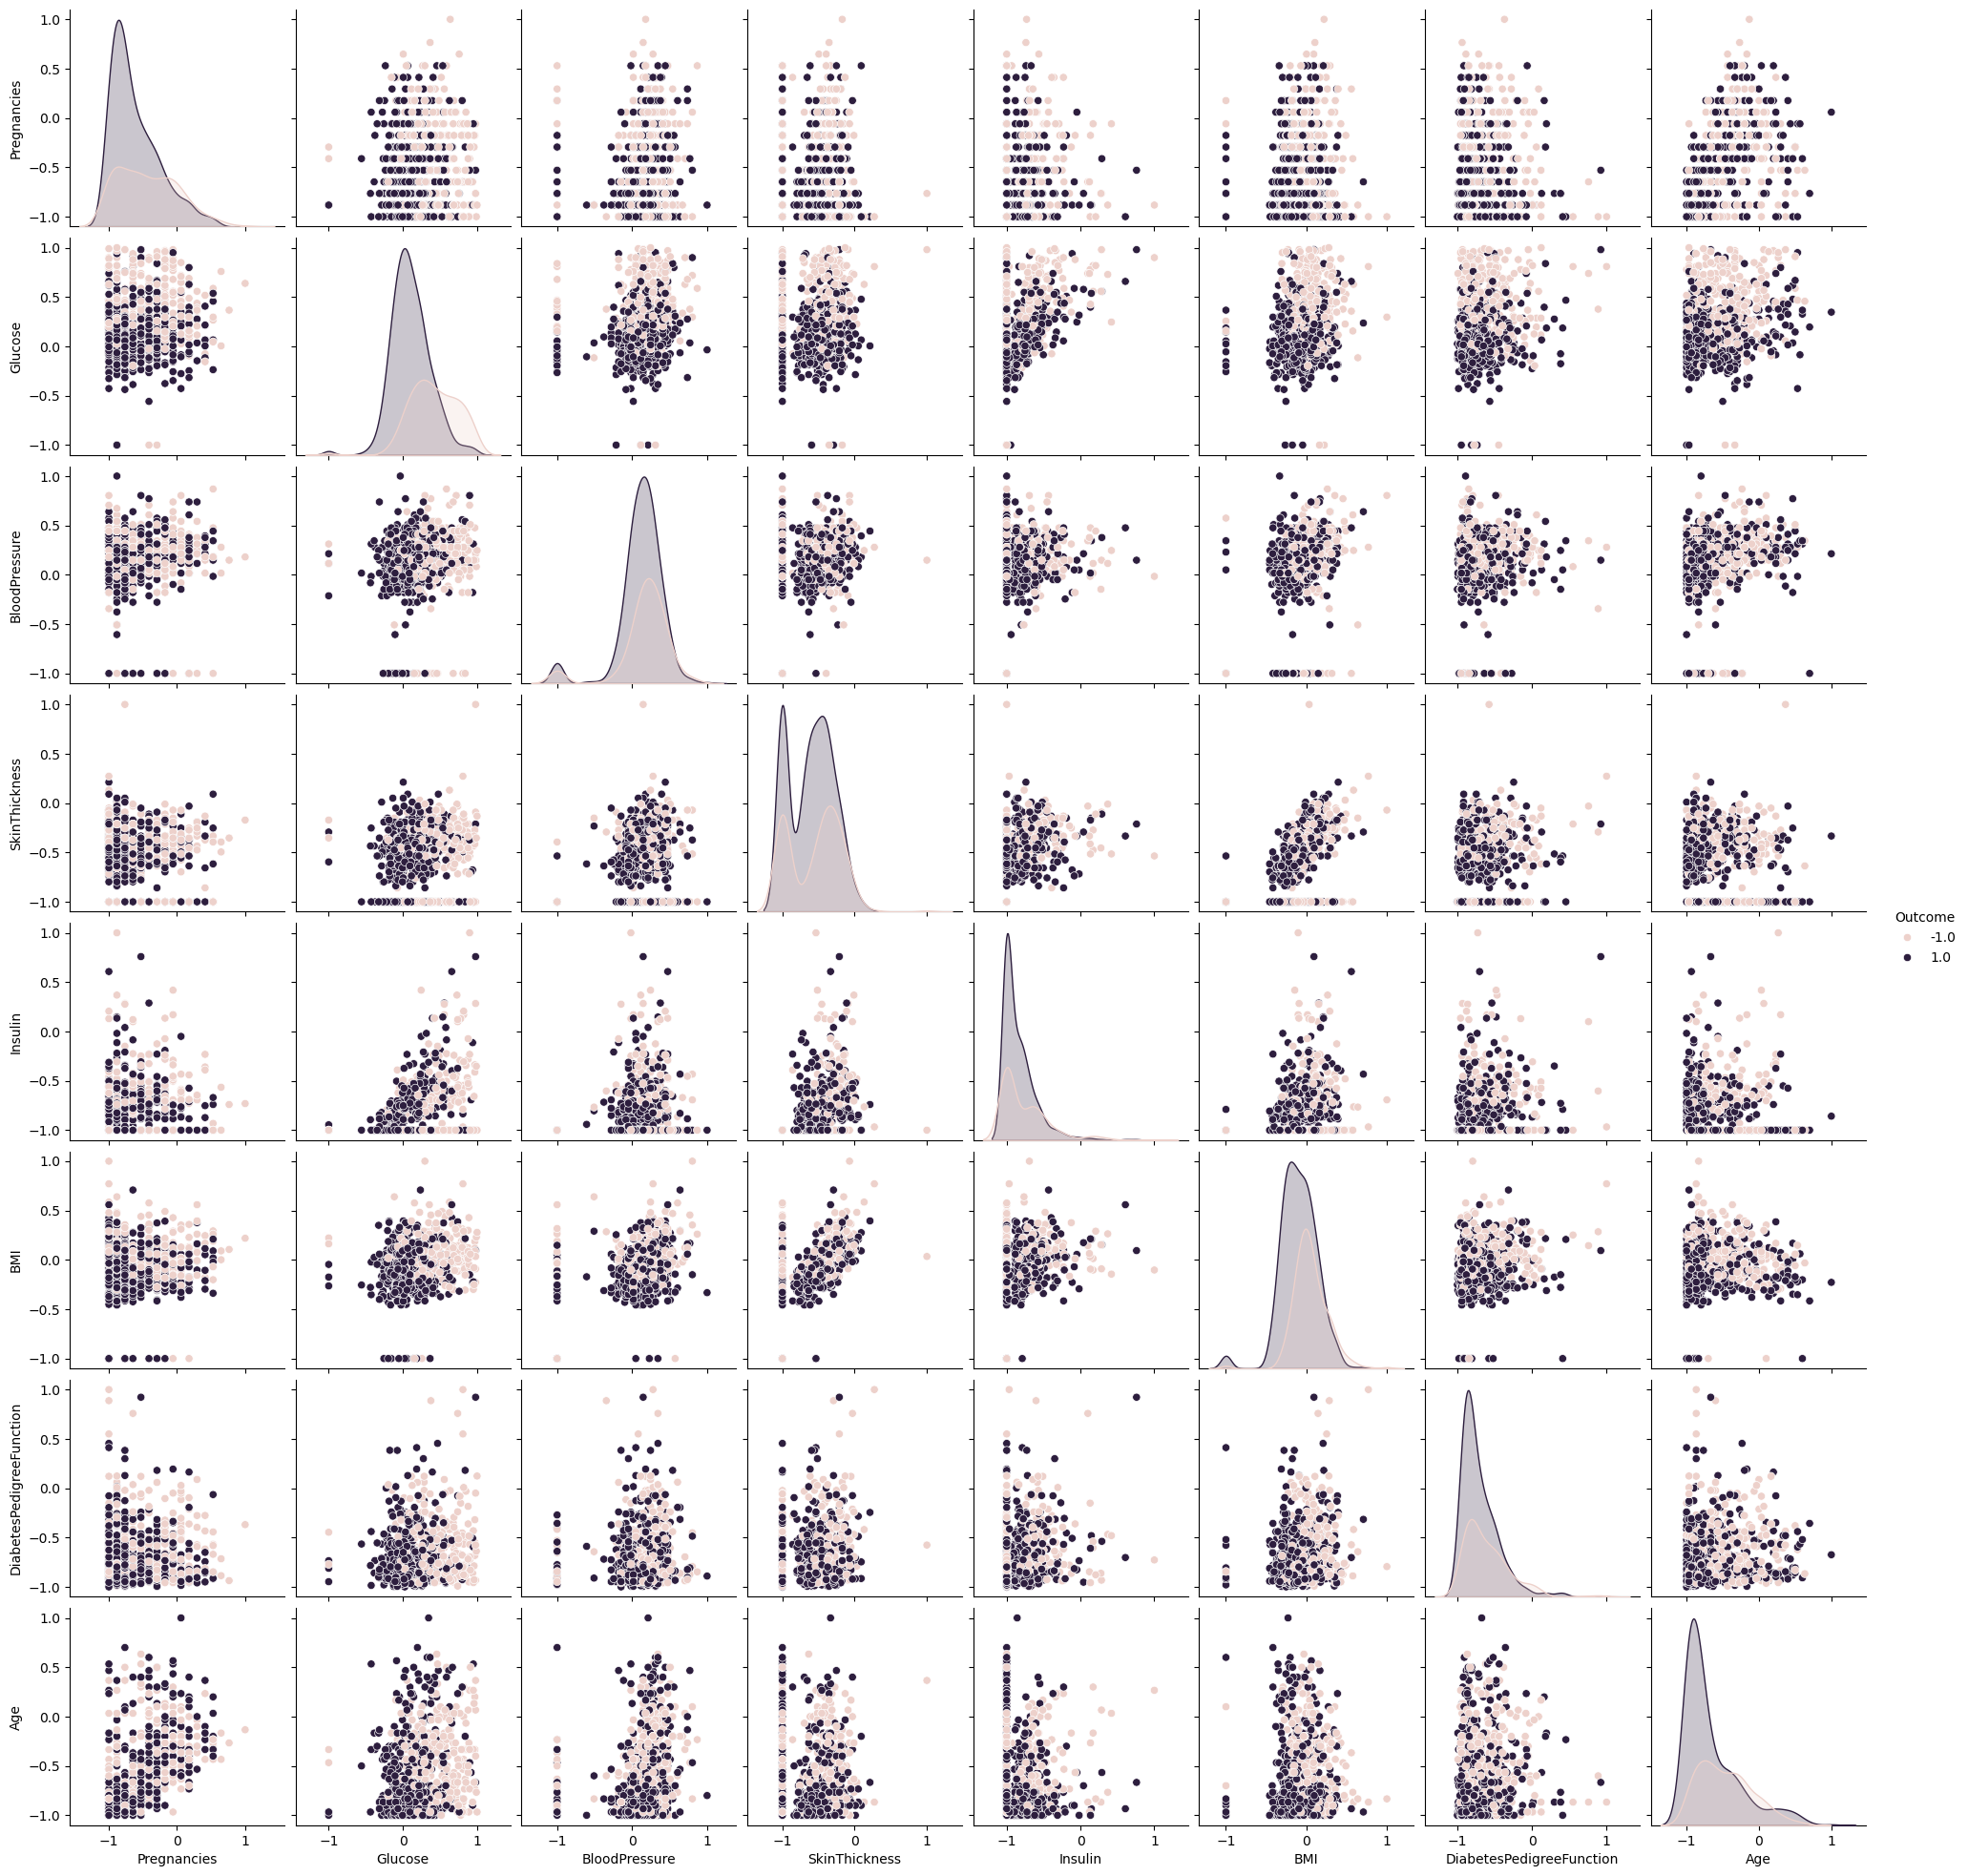

In [6]:
# Plot pairwise relationships
sns.pairplot(df, hue='Outcome', diag_kind='kde')
plt.show()

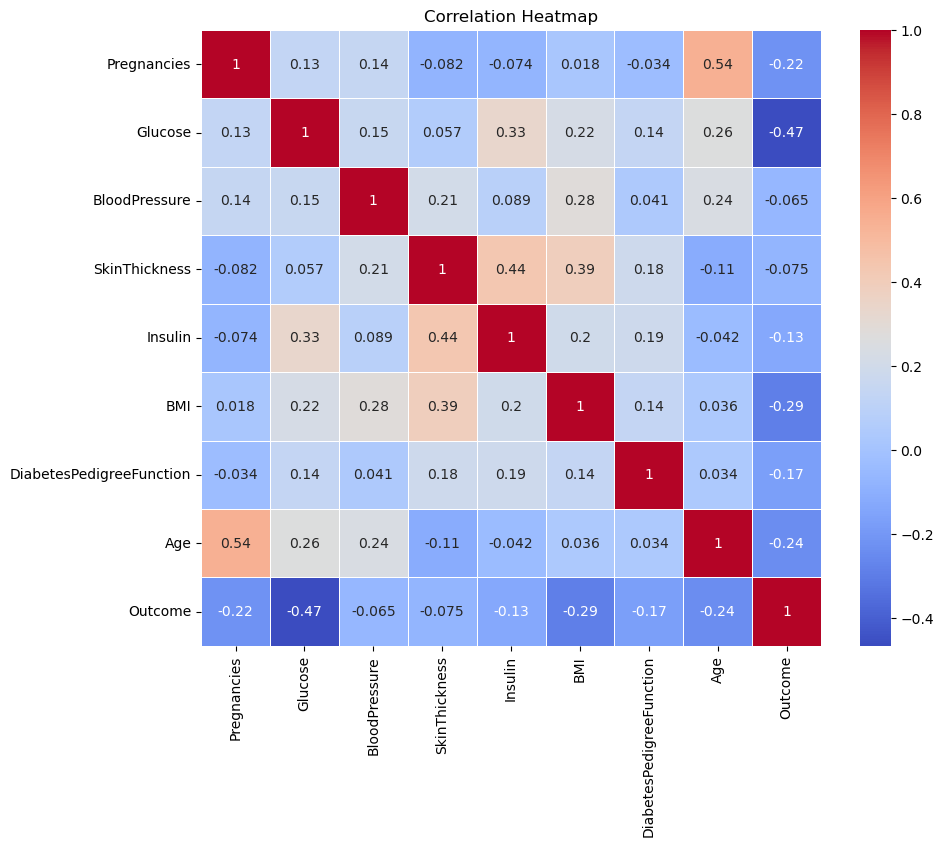

In [7]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

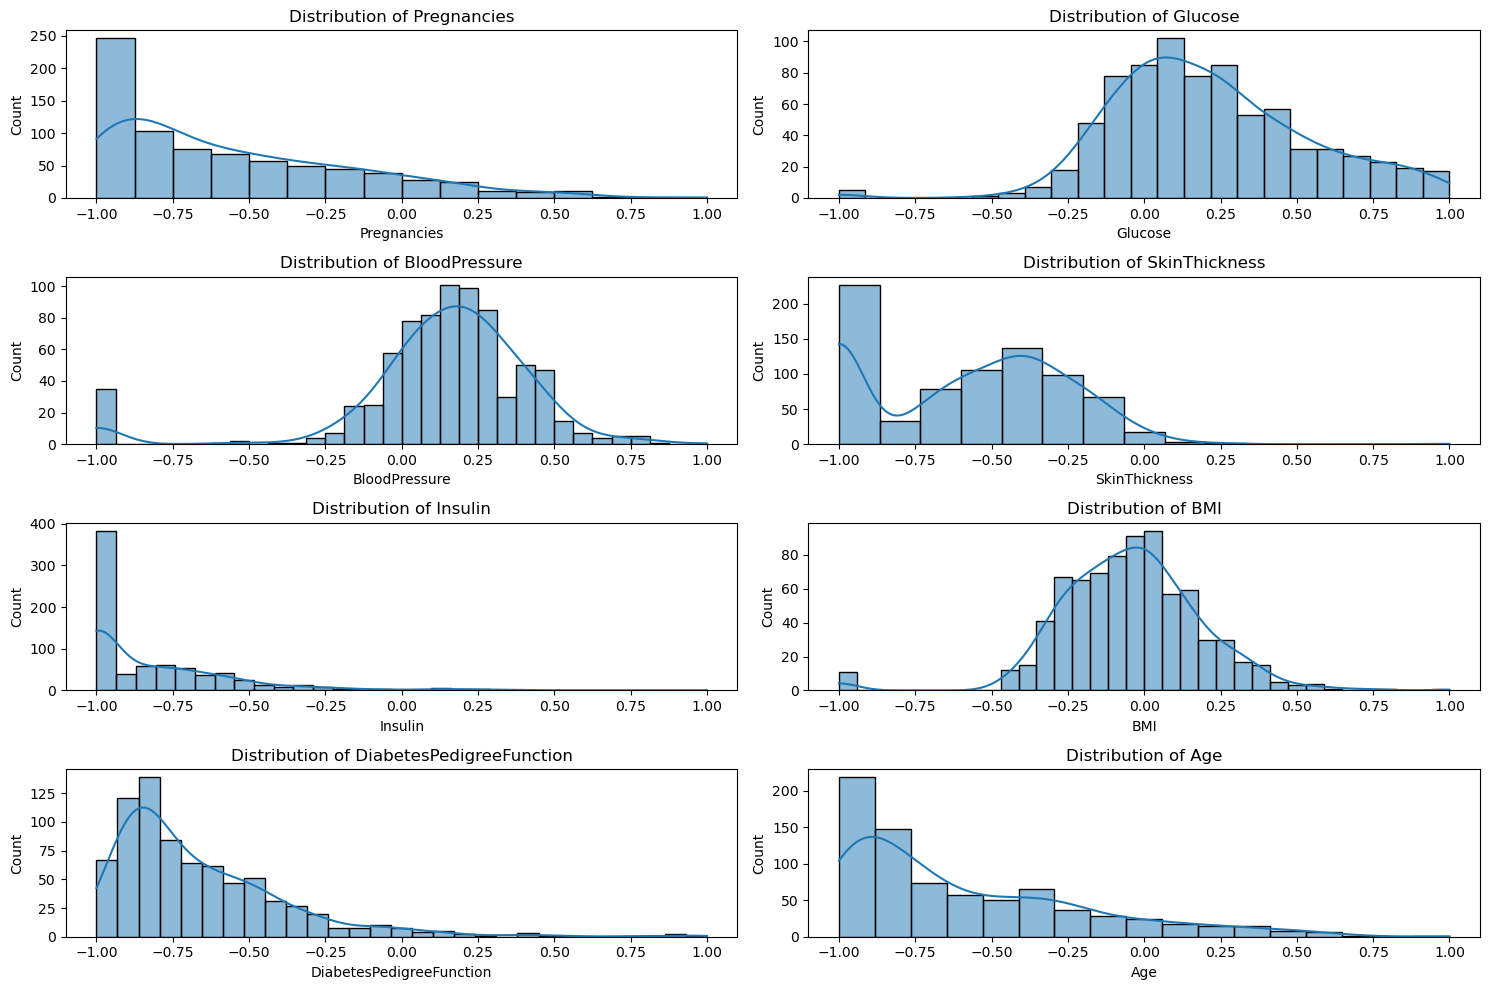

In [8]:
# Visualize distribution of each feature using Seaborn's distplot
plt.figure(figsize=(15, 10))
for i, column in enumerate(df.columns[:-1]):  # Exclude the Outcome column for feature distribution plots
    plt.subplot(4, 2, i + 1)
    sns.histplot(df[column], kde=True)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()


In [9]:

# Train-test split with the full feature set
X_train, X_test, y_train, y_test = train_test_split(data_dense, target, test_size=0.2, random_state=42)

# Verify the split
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: (614, 8)
Test data shape: (154, 8)


In [10]:
# --------------------------------------------------------------------------------
# Custom Perceptron Class with Additional Functionality
# --------------------------------------------------------------------------------
class PerceptronSKLearn(BaseEstimator, ClassifierMixin):
    def __init__(self, learning_rate=0.01, epochs=100):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weights = None
        self.bias = None
        self.classes_ = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        self.classes_ = np.unique(y)  # Store the unique class labels
        for _ in range(self.epochs):
            for idx, x_i in enumerate(X):
                linear_output = np.dot(x_i, self.weights) + self.bias
                y_predicted = np.sign(linear_output)
                if y[idx] * y_predicted <= 0:  # Misclassified
                    self.weights += self.learning_rate * y[idx] * x_i
                    self.bias += self.learning_rate * y[idx]
        return self

    def predict(self, X):
        linear_output = np.dot(X, self.weights) + self.bias
        y_pred = np.sign(linear_output)
        y_pred = np.where(y_pred == -1, self.classes_[0], self.classes_[1])
        return y_pred

In [11]:
# --------------------------------------------------------------------------------
# Experiment 1: Normal Perceptron with Full Feature Set
# --------------------------------------------------------------------------------
print("\n========== Normal Perceptron Output ==========")

# Initialize and train Perceptron
normal_perceptron = PerceptronSKLearn()
normal_perceptron.fit(X_train, y_train)

# Predictions
normal_predictions = normal_perceptron.predict(X_test)

# Evaluate using multiple metrics
normal_recall = recall_score(y_test, normal_predictions, pos_label=1)
precision = precision_score(y_test, normal_predictions, pos_label=1)
f1 = f1_score(y_test, normal_predictions, pos_label=1)
accuracy = accuracy_score(y_test, normal_predictions)

print(f"Recall: {normal_recall * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")
print(f"Accuracy: {accuracy * 100:.2f}%")



========== Normal Perceptron Output ==========
Recall: 64.65%
Precision: 87.67%
F1 Score: 74.42%
Accuracy: 71.43%


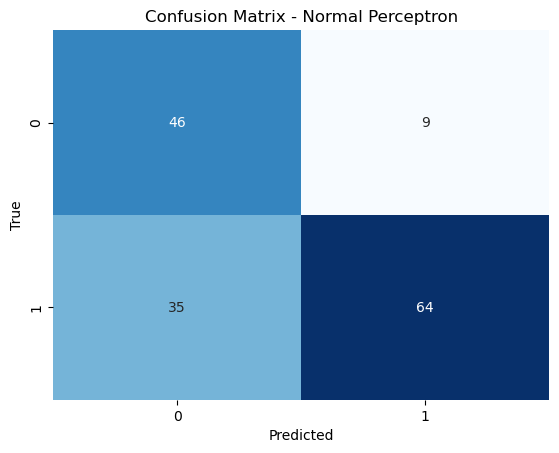

In [12]:
# Confusion matrix for normal perceptron
cm_normal = confusion_matrix(y_test, normal_predictions)
sns.heatmap(cm_normal, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Normal Perceptron')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [13]:
# --------------------------------------------------------------------------------
# Experiment 2: GridSearchCV to Tune Perceptron Hyperparameters
# --------------------------------------------------------------------------------
print("\n========== GridSearch Perceptron Output ==========")

pipeline = Pipeline([
    ('classifier', PerceptronSKLearn())  # Insert Perceptron model into the pipeline
])

param_grid = {
    'classifier__learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.5, 1],
    'classifier__epochs': [50, 100, 200, 500]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='recall')
grid_search.fit(X_train, y_train)

# Best parameters from GridSearch
best_params = grid_search.best_params_
print(f"Best Parameters from GridSearchCV: {best_params}")

# Evaluate using the best model
best_model = grid_search.best_estimator_
test_predictions_pipeline = best_model.predict(X_test)

test_recall_pipeline = recall_score(y_test, test_predictions_pipeline, pos_label=1)
test_precision_pipeline = precision_score(y_test, test_predictions_pipeline, pos_label=1)
test_f1_pipeline = f1_score(y_test, test_predictions_pipeline, pos_label=1)
test_accuracy_pipeline = accuracy_score(y_test, test_predictions_pipeline)

print(f"Recall: {test_recall_pipeline * 100:.2f}%")
print(f"Precision: {test_precision_pipeline * 100:.2f}%")
print(f"F1 Score: {test_f1_pipeline * 100:.2f}%")
print(f"Accuracy: {test_accuracy_pipeline * 100:.2f}%")





========== GridSearch Perceptron Output ==========
Best Parameters from GridSearchCV: {'classifier__epochs': 500, 'classifier__learning_rate': 0.0001}
Recall: 78.79%
Precision: 82.98%
F1 Score: 80.83%
Accuracy: 75.97%


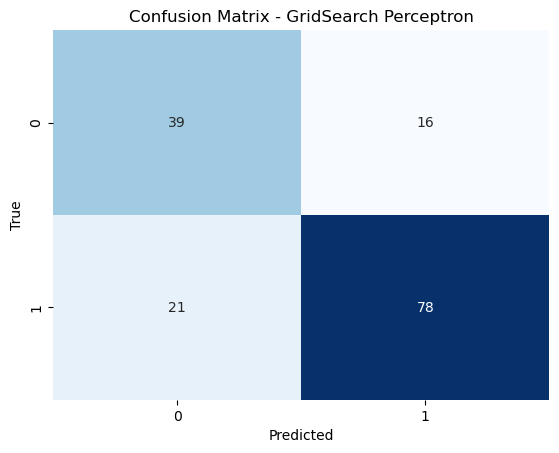

In [14]:
cm_pipeline = confusion_matrix(y_test, test_predictions_pipeline)
sns.heatmap(cm_pipeline, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - GridSearch Perceptron')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


========== Feature Importance Visualization After GridSearchCV ==========


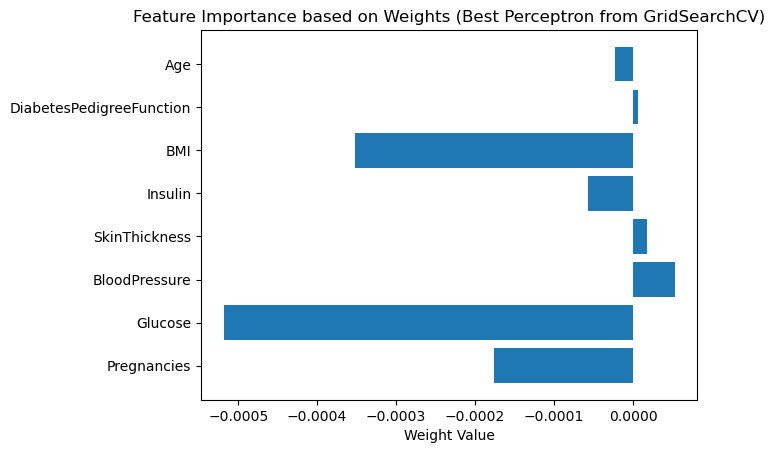

In [15]:
print("\n========== Feature Importance Visualization After GridSearchCV ==========")

# Extract the best model from GridSearchCV
best_perceptron = best_model.named_steps['classifier']

# Visualizing feature importance based on weights from the best model
plt.barh(df.columns[:-1], best_perceptron.weights)
plt.title('Feature Importance based on Weights (Best Perceptron from GridSearchCV)')
plt.xlabel('Weight Value')
plt.show()

In [16]:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                # --------------------------------------------------------------------------------
# Experiment 3: Perceptron with Reduced Feature Set
# --------------------------------------------------------------------------------
print("\n========== Perceptron Output with Reduced Features ==========")

# Drop less important features (BloodPressure and SkinThickness)
df_reduced = df.drop(columns=['BloodPressure', 'SkinThickness'])
X_reduced = df_reduced.drop(columns=['Outcome'])
y_reduced = df_reduced['Outcome']

# Train-test split with reduced feature set
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(
    X_reduced, y_reduced, test_size=0.2, random_state=42)

# Convert to numpy arrays and ensure float64 dtype
X_train_reduced = X_train_reduced.values.astype(np.float64)
X_test_reduced = X_test_reduced.values.astype(np.float64)
y_train_reduced = y_train_reduced.values.astype(np.float64)
y_test_reduced = y_test_reduced.values.astype(np.float64)

# Train and predict
perceptron_reduced = PerceptronSKLearn()
perceptron_reduced.fit(X_train_reduced, y_train_reduced)
predictions_reduced = perceptron_reduced.predict(X_test_reduced)

# Evaluate reduced feature model
recall_reduced = recall_score(y_test_reduced, predictions_reduced, pos_label=1)
precision_reduced = precision_score(y_test_reduced, predictions_reduced, pos_label=1)
f1_reduced = f1_score(y_test_reduced, predictions_reduced, pos_label=1)
accuracy_reduced = accuracy_score(y_test_reduced, predictions_reduced)

print(f"Recall with reduced features: {recall_reduced * 100:.2f}%")
print(f"Precision with reduced features: {precision_reduced * 100:.2f}%")
print(f"F1 Score with reduced features: {f1_reduced * 100:.2f}%")
print(f"Accuracy with reduced features: {accuracy_reduced * 100:.2f}%")



========== Perceptron Output with Reduced Features ==========
Recall with reduced features: 93.94%
Precision with reduced features: 77.50%
F1 Score with reduced features: 84.93%
Accuracy with reduced features: 78.57%


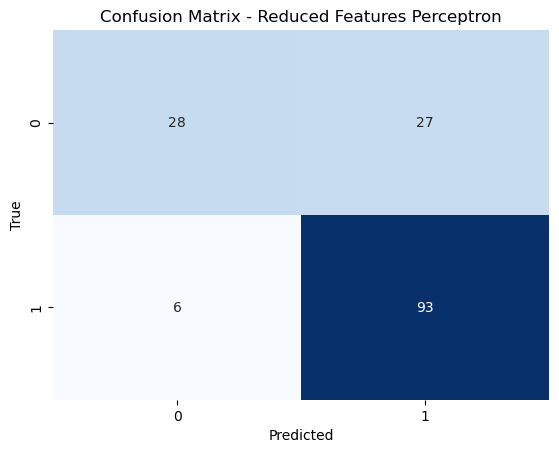

In [17]:

# Confusion matrix for reduced feature set
cm_reduced = confusion_matrix(y_test_reduced, predictions_reduced)
sns.heatmap(cm_reduced, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Reduced Features Perceptron')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [18]:
from sklearn.linear_model import LogisticRegression

# --------------------------------------------------------------------------------
# Experiment 4: Logistic Regression Model
# --------------------------------------------------------------------------------
print("\n========== Logistic Regression Output ==========")

# Initialize the Logistic Regression model
log_reg_model = LogisticRegression(max_iter=1000, solver='liblinear')  # liblinear is good for smaller datasets

# Train the Logistic Regression model
log_reg_model.fit(X_train, y_train)

# Predict using the Logistic Regression model
log_reg_predictions = log_reg_model.predict(X_test)

# Evaluate the Logistic Regression model
log_reg_recall = recall_score(y_test, log_reg_predictions, pos_label=1)
log_reg_precision = precision_score(y_test, log_reg_predictions, pos_label=1)
log_reg_f1 = f1_score(y_test, log_reg_predictions, pos_label=1)
log_reg_accuracy = accuracy_score(y_test, log_reg_predictions)

print(f"Recall (Logistic Regression): {log_reg_recall * 100:.2f}%")
print(f"Precision (Logistic Regression): {log_reg_precision * 100:.2f}%")
print(f"F1 Score (Logistic Regression): {log_reg_f1 * 100:.2f}%")
print(f"Accuracy (Logistic Regression): {log_reg_accuracy * 100:.2f}%")




========== Logistic Regression Output ==========
Recall (Logistic Regression): 80.81%
Precision (Logistic Regression): 80.81%
F1 Score (Logistic Regression): 80.81%
Accuracy (Logistic Regression): 75.32%


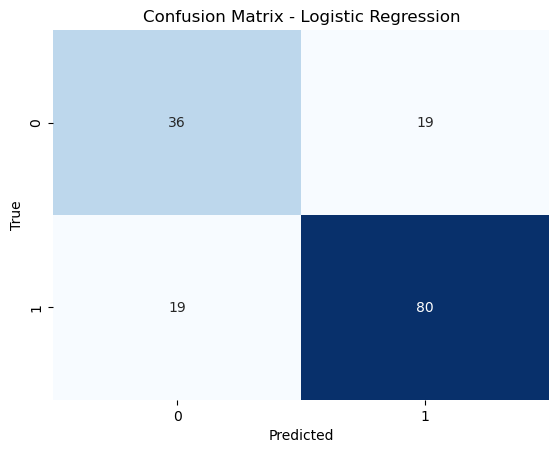

In [19]:
# Confusion matrix for Logistic Regression model
cm_log_reg = confusion_matrix(y_test, log_reg_predictions)
sns.heatmap(cm_log_reg, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


========== Comparison of All Experiments ==========
                         Model     Recall  Precision   F1 Score   Accuracy
0            Normal Perceptron  64.646465  87.671233  74.418605  71.428571
1        GridSearch Perceptron  78.787879  82.978723  80.829016  75.974026
2  Perceptron Reduced Features  93.939394  77.500000  84.931507  78.571429
3          Logistic Regression  80.808081  80.808081  80.808081  75.324675


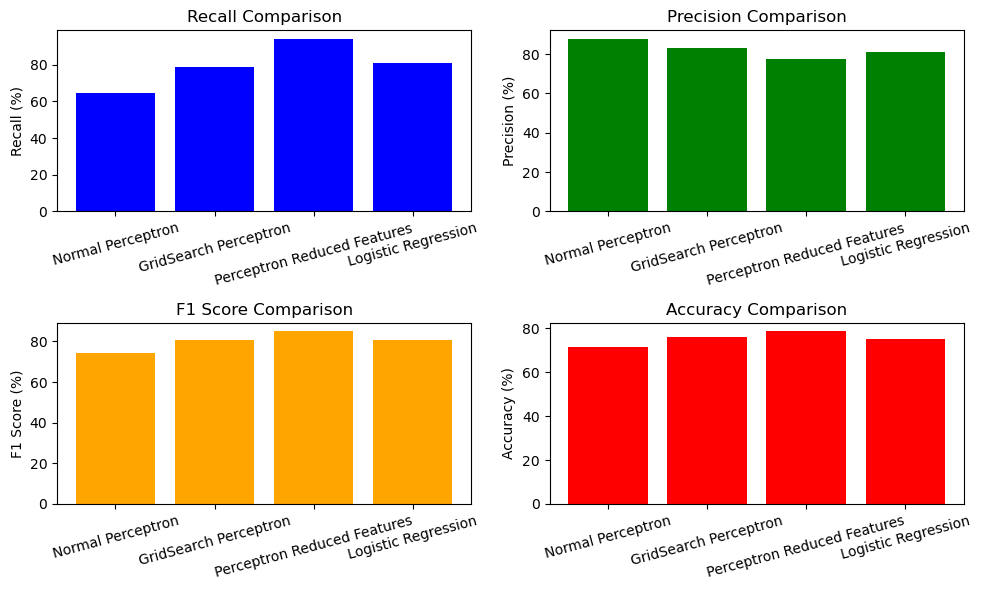

In [20]:


# --------------------------------------------------------------------------------
# Collecting Results from All Experiments
# --------------------------------------------------------------------------------

# Experiment 1: Normal Perceptron (already stored in normal_recall, precision, f1, accuracy)
results = {
    'Model': ['Normal Perceptron', 'GridSearch Perceptron', 'Perceptron Reduced Features', 'Logistic Regression'],
    'Recall': [normal_recall * 100, test_recall_pipeline * 100, recall_reduced * 100, log_reg_recall * 100],
    'Precision': [precision * 100, test_precision_pipeline * 100, precision_reduced * 100, log_reg_precision * 100],
    'F1 Score': [f1 * 100, test_f1_pipeline * 100, f1_reduced * 100, log_reg_f1 * 100],
    'Accuracy': [accuracy * 100, test_accuracy_pipeline * 100, accuracy_reduced * 100, log_reg_accuracy * 100]
}

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# --------------------------------------------------------------------------------
# Print Results in a Table
# --------------------------------------------------------------------------------
print("\n========== Comparison of All Experiments ==========")
print(results_df)

# --------------------------------------------------------------------------------
# Plotting the Results for Comparison
# --------------------------------------------------------------------------------
# Set up the figure and axes for subplots
plt.figure(figsize=(10, 6))

# Recall Comparison
plt.subplot(2, 2, 1)
plt.bar(results_df['Model'], results_df['Recall'], color='blue')
plt.title('Recall Comparison')
plt.ylabel('Recall (%)')
plt.xticks(rotation=15)

# Precision Comparison
plt.subplot(2, 2, 2)
plt.bar(results_df['Model'], results_df['Precision'], color='green')
plt.title('Precision Comparison')
plt.ylabel('Precision (%)')
plt.xticks(rotation=15)

# F1 Score Comparison
plt.subplot(2, 2, 3)
plt.bar(results_df['Model'], results_df['F1 Score'], color='orange')
plt.title('F1 Score Comparison')
plt.ylabel('F1 Score (%)')
plt.xticks(rotation=15)

# Accuracy Comparison
plt.subplot(2, 2, 4)
plt.bar(results_df['Model'], results_df['Accuracy'], color='red')
plt.title('Accuracy Comparison')
plt.ylabel('Accuracy (%)')
plt.xticks(rotation=15)

# Adjust layout for readability
plt.tight_layout()
plt.show()

